Họ và tên: Phạm Đức Thể

MSSV: 19522253

Lớp: DS310.M11

Lab 03 - 28/10/2021

# Câu 1: Sử dụng mô hình LSTM để giải quyết bài toán NER cho tiếng Anh.

## Bước 1: Import Modules

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import seaborn as sn
import numpy as np
import requests
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.6.0
GPU detected: []


## Bước 2: Load bộ dữ liệu NER

Thông tin các thực thể:

geo = Geographical Entity\
org = Organization\
per = Person\
gpe = Geopolitical Entity\
tim = Time indicator\
art = Artifact\
eve = Event\
nat = Natural Phenomenon

Sau khi đọc tập dữ liệu, chúng ta quan sát thử 50 dòng đầu tiên như thế nào.


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/ner_dataset.csv',encoding="latin1")
data = data.fillna(method="ffill")
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


## Visualizing the Sentenceentence
Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu. (Tập từ vựng, số chiều)
- Số lượng thẻ duy nhất trong tập dữ liệu. (Tập nhãn)


Bằng cách sử dụng hàm **“nunique”.**

In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
print(words)
print(num_words)

['uncover', 'RCT', '3.29', 'Warwrinka', 'kidnapped', 'shunned', 'maximum', '5,10,000', 'package', 'Seventy-three', 'CPP', 'deployed', 'al-Harith', 'Rak', 'whispers', 'barcodes', 'quirky', 'congressional', 'Lopez', 'Follow', 'Giuliani', 'Rony', 'capabilities', 'victor', 'townships', 'welcome', 'Guizhou', 'faltering', 'anti-Maoist', 'Arab-Israeli', 'censor', 'commissioned', 'Broadcaster', 'Nino', 'apprehension', 'conference', 'Guji', 'non-disbursing', 'glasnost', 'cadmium', 'sunk', 'inspire', 'defamatory', 'NORAD', 'Eutelsat', 're-stating', 'lags', 'domestically', 'Jake', 'inflammatory', 'ducked', 'instability', '30-day', 'trousers', 'steady', 'evil', 'disagrees', 'Hayden', '46-member', 'prime', 'Bush-Clinton', 'interviewers', 'Hamas-led', 'monk', 'CRANES', 'one-on-one', 'France-3', 'blood', 'begged', 'Sullivan', 'Bel-Air', 'offside', 'Scottish', 'robbed', 'housing', 'Hortefeux', 'Domm', 'tramway', 'Mayor', 'Armenian', 'Saada', 'preview', 'Rift', 'Fears', 'Al-Said', 'panels', 'Drel', 'pr

In [6]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [7]:
print(tags)

['I-geo', 'B-nat', 'B-geo', 'B-tim', 'O', 'I-per', 'B-eve', 'B-per', 'I-nat', 'I-org', 'B-art', 'I-art', 'I-tim', 'B-org', 'I-eve', 'B-gpe', 'I-gpe']


In [8]:
print('Tổng số từ duy nhất:', num_words)
print('Số lượng nhãn thực thể:', num_tags)

Tổng số từ duy nhất: 35179
Số lượng nhãn thực thể: 17


## Bước 3: Lấy các câu và các thẻ tương ứng

In [9]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

#các bạn có thể viết theo cách khác

In [10]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [11]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

## Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [12]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
# word2idx
# word2idx["ENDPAD"]
tag2idx 

{'B-art': 10,
 'B-eve': 6,
 'B-geo': 2,
 'B-gpe': 15,
 'B-nat': 1,
 'B-org': 13,
 'B-per': 7,
 'B-tim': 3,
 'I-art': 11,
 'I-eve': 14,
 'I-geo': 0,
 'I-gpe': 16,
 'I-nat': 8,
 'I-org': 9,
 'I-per': 5,
 'I-tim': 12,
 'O': 4}

## Bước 5: Padding  đầu vào và cắt dữ liệu thành tập Train/Test
Trong trục X, có thể thấy độ dài an toàn của câu là khoảng 50.

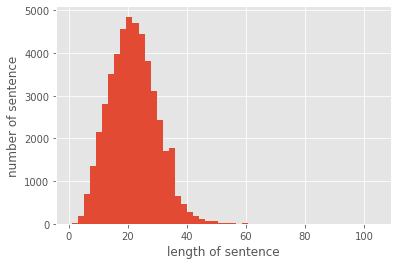

In [14]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [16]:
print(X[0])
print(y[0])

[29689 26462 18230 24475 10363 11110 17603   558 31299 17937 13024 12076
 19119  2430 19394 17937 25423 26462 12359   935 23542 12432  3620   228
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[ 4  4  4  4  4  4  2  4  4  4  4  4  2  4  4  4  4  4 15  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4]


- test_size = 0.2 có nghĩa là 80% dữ liệu chia cho tập huấn luyện và 20% còn lại cho tập kiểm tra.

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Bước 6: Xây dựng Mô hình LSTM hai chiều (bi-LSTM)


In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

Bản tóm tắt cho thấy rằng chúng ta có hơn 1,88 triệu tham số cần được huấn luyện.

In [19]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


- Sử dụng trình tối ưu hoá "adam"
- sparce_categorical_crossentropy làm hàm mất mát
- Ma trận mà chúng ta sẽ quan tâm là ma trận độ chính xác.

In [20]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# Dừng sớm để tránh overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Bước 7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [21]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(x=x_train, y=y_train, validation_split= 0.1,
                    batch_size= 32, epochs=10, callbacks=[callback])

print("[{}] Completed!".format(time.time() - start_time))

Epoch 1/10
1080/1080 [==============================] - 203s 184ms/step - loss: 0.1865 - accuracy: 0.9574 - val_loss: 0.0663 - val_accuracy: 0.9809
Epoch 2/10
1080/1080 [==============================] - 198s 184ms/step - loss: 0.0521 - accuracy: 0.9846 - val_loss: 0.0495 - val_accuracy: 0.9847
Epoch 3/10
1080/1080 [==============================] - 200s 185ms/step - loss: 0.0376 - accuracy: 0.9885 - val_loss: 0.0470 - val_accuracy: 0.9857
Epoch 4/10
1080/1080 [==============================] - 199s 184ms/step - loss: 0.0310 - accuracy: 0.9902 - val_loss: 0.0496 - val_accuracy: 0.9852
Epoch 5/10
1080/1080 [==============================] - 199s 184ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0476 - val_accuracy: 0.9859
Epoch 6/10
1080/1080 [==============================] - 199s 185ms/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 0.0505 - val_accuracy: 0.9857
[1198.6777007579803] Completed!


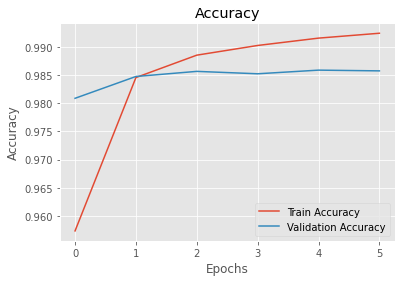

In [22]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

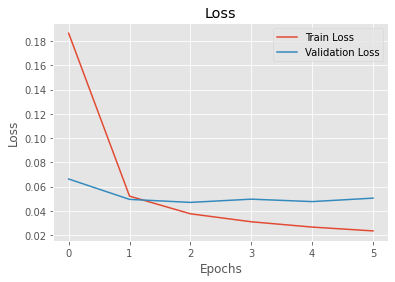

In [23]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Bước 8: Đánh giá mô hình NER



In [24]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 8s 25ms/step - loss: 0.0489 - accuracy: 0.9854


[0.04891343414783478, 0.9853586554527283]

- Dự đoán

In [25]:
# i = np.random.randint(0, x_test.shape[0]) #659
print(x_test[1])
i = 2
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:25}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:25}{:5}\t{}".format(words[w-1], tags[true], tags[pred]))

[32186 23200 10352  9971 35148 30211 33984 20261 20449 30124 18213 13438
  8267  1982  2753 30211 20720 18145  1982  8267 22249 19745    67  1640
 33946 19959   228 19745 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
Word                     True 	 Pred

------------------------------
connection               O    	O
bruises                  O    	O
regular                  O    	O
515                      O    	O
multinational            O    	O
steals                   O    	O
conservation             O    	O
Ramos                    B-geo	B-org
Resource                 I-geo	I-org
Chikunova                O    	O
Ashley                   O    	O
Gwangju                  O    	O
Syrian-Lebanese          O    	O
Sa'eed                   B-tim	B-tim
amortization             O    	O
Lateef                   O    	O
Lateef                   O    	O
Lateef                   O    	O
Lateef             

## Bước 9: Yêu cầu

### Đánh giá mô hình theo độ đo F1-score

In [26]:
!pip install seqeval

predict tập test

In [27]:
y_true = []
y_pred = []
for i in range(y_test.shape[0]):
  y_true.append(y_test[i])
  p = model.predict(np.array([x_test[i]]))
  p = np.argmax(p, axis=-1)
  y_pred.extend(p)

In [28]:
Y_true = []
Y_pred = []

for i, j in zip(range(len(y_true)), range(len(y_pred))):
  true = []
  pred = []
  for k in range(len(y_true[i])):
    true.append(tags[y_true[i][k]])
    pred.append(tags[y_pred[j][k]])
  Y_true.append(true)
  Y_pred.append(pred)

In [29]:
from seqeval.metrics import f1_score

print('F1-score micro test set: {}%'.format(round(f1_score(Y_true, Y_pred, average='micro')*100,2)))
print('F1-score macro test set: {}%'.format(round(f1_score(Y_true, Y_pred, average='macro')*100,2)))

F1-score micro test set: 80.3%
F1-score macro test set: 53.76%


### F1-score và Accuracy cho từng nhãn thực thể. 

#### F1-score

In [30]:
from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  """Entry point for launching an IPython kernel.


In [31]:
YT = list(flatten(Y_true))
YP = list(flatten(Y_pred))

In [32]:
from sklearn.metrics import classification_report as sklearn_cs

print(sklearn_cs(YT, YP))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        96
       B-eve       0.82      0.18      0.29        79
       B-geo       0.86      0.88      0.87      7380
       B-gpe       0.96      0.93      0.94      3173
       B-nat       0.00      0.00      0.00        38
       B-org       0.74      0.73      0.73      3908
       B-per       0.85      0.80      0.82      3359
       B-tim       0.91      0.87      0.89      4102
       I-art       0.00      0.00      0.00        86
       I-eve       0.00      0.00      0.00        73
       I-geo       0.81      0.76      0.78      1449
       I-gpe       0.94      0.52      0.67        33
       I-nat       0.00      0.00      0.00        12
       I-org       0.76      0.78      0.77      3254
       I-per       0.88      0.83      0.85      3424
       I-tim       0.79      0.74      0.76      1339
           O       0.99      1.00      1.00    447795

    accuracy              

In [33]:
from seqeval.metrics import classification_report as seqeval_cs

print(seqeval_cs(Y_true, Y_pred, digits =4))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art     0.0000    0.0000    0.0000        96
         eve     0.8235    0.1772    0.2917        79
         geo     0.8399    0.8692    0.8543      7380
         gpe     0.9600    0.9297    0.9446      3173
         nat     0.0000    0.0000    0.0000        38
         org     0.6233    0.6809    0.6508      3908
         per     0.7222    0.7149    0.7185      3360
         tim     0.8445    0.8379    0.8412      4102

   micro avg     0.7984    0.8077    0.8030     22136
   macro avg     0.6017    0.5262    0.5376     22136
weighted avg     0.7967    0.8077    0.8011     22136



#### Accuracy

In [34]:
from seqeval.metrics import accuracy_score

accuracy = round(accuracy_score(Y_true, Y_pred)*100,2)
print('Accuracy test = {}%'.format(accuracy))

Accuracy test = 98.54%


Confusion matrix với các nhãn tương ứng như sau

B-art - 0    
B-eve - 1      
B-geo - 2      
B-gpe - 3      
B-nat - 4      
B-org - 5      
B-per - 6      
B-tim - 7      
I-art - 8     
I-eve - 9      
I-geo - 10      
I-gpe - 11      
I-nat - 12      
I-org - 13      
I-per - 14      
I-tim - 15      
O     - 16  

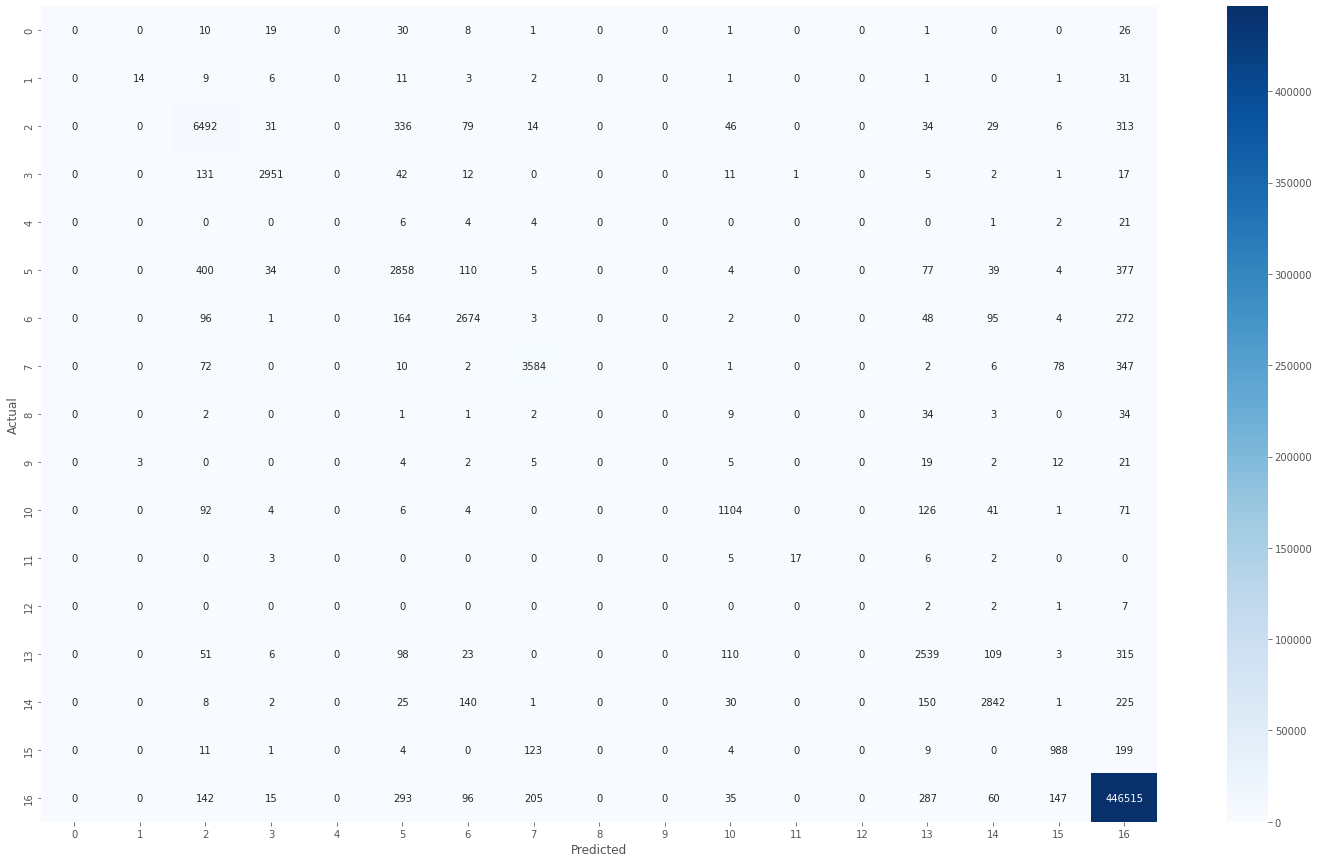

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(YT, YP) 
plt.figure(figsize=(25,15))
sn.heatmap(cm, annot=True, cmap = 'Blues', fmt='g', cbar=True, annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
labels=["B-art", "B-eve", "B-geo", "B-gpe", "B-nat", "B-org", "B-per", "B-tim", 
        "I-art", "I-eve", "I-geo", "I-gpe", "I-nat", "I-org", "I-per", "I-tim", "O"]
# Accuracy của từng nhãn thực thể
acc_class = cm.diagonal()/cm.sum(axis=1) 
df_acc_class = pd.DataFrame({'Label': labels,
                             'Accuracy': acc_class})
df_acc_class

,Label,Accuracy
0,B-art,0.000000
1,B-eve,0.177215
2,B-geo,0.879675
3,B-gpe,0.930035
4,B-nat,0.000000
5,B-org,0.731320
6,B-per,0.796070
7,B-tim,0.873720
8,I-art,0.000000
9,I-eve,0.000000


### Lưu lại mô hình và bộ trọng số đã train. 

In [37]:
# Chuyển đến thư mục cần lưu model
%cd '/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021'

/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021


In [38]:
pwd

'/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021'

In [39]:
ls

NER_Câu1_LSTM_19522253.ipynb       NER_Câu2_LSTM_19522253_model.h5
NER_Câu1_LSTM_19522253_model.h5    NER_Câu2_LSTM_19522253_weights.h5
NER_Câu1_LSTM_19522253_weights.h5  NER_Câu2_RNN_19522253.ipynb
NER_Câu1_RNN_19522253.ipynb        NER_Câu2_RNN_19522253_model.h5
NER_Câu1_RNN_19522253_model.h5     NER_Câu2_RNN_19522253_weights.h5
NER_Câu1_RNN_19522253_weights.h5   ner_dataset.csv
NER_Câu2_LSTM_19522253.ipynb       NER-LSTM.ipynb


In [40]:
# Lưu bộ trọng số đã train
model.save_weights('NER_Câu1_LSTM_19522253_weights.h5')

In [41]:
# Lưu mô hình đã train
model.save('NER_Câu1_LSTM_19522253_model.h5')